# Regression models on NFL data

The process is to train the models on the 2021 data and then use those models to predict the probability of the Cowboys winning in 2022. Unfortunately, the 2022 data is so biased after only one game that all models tend to predict wins over teams who have lost their first game of 2022. Really, there just aren't enough usable input columns. Or I need your help in devising new calculated columns that contain a lot of information and yet do not get skewed by comparing one whole season to a season that currently only contains one game. Ideally, as the 2022 season progreses, the predictions should become better.

But, at least you can see how easy it is to code some pretty advanced statistical analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import math

### Load the 2021 stats data

In [2]:
stats_df = pd.read_csv("pfr_2021_stats.csv", index_col=0)
stats_df.index = stats_df.index.map(lambda name: name.strip(string.punctuation))
stats_df

,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS
Tm,,,,,,,,,,,,
Buffalo Bills,11,6,0,0.647,483,289,194,11.4,-1.6,9.8,5.0,4.8
New England Patriots,10,7,0,0.588,462,303,159,9.4,-0.9,8.5,3.6,4.8
Miami Dolphins,9,8,0,0.529,341,373,-32,-1.9,-0.8,-2.7,-3.1,0.3
New York Jets,4,13,0,0.235,310,504,-194,-11.4,1.0,-10.4,-3.6,-6.7
Cincinnati Bengals,10,7,0,0.588,460,376,84,4.9,-1.9,3.1,3.4,-0.3
Pittsburgh Steelers,9,7,1,0.559,343,398,-55,-3.2,0.8,-2.5,-2.6,0.1
Cleveland Browns,8,9,0,0.471,349,371,-22,-1.3,0.0,-1.3,-2.7,1.3
Baltimore Ravens,8,9,0,0.471,387,392,-5,-0.3,0.0,-0.3,-0.3,0.0
Tennessee Titans,12,5,0,0.706,419,354,65,3.8,-0.4,3.4,1.8,1.6


### Load the 2021 results data

In [3]:
def is_home(str):
    if str == "@":
        return 0.0
    if type(str) == float and math.isnan(str):
        return 1.0
    raise Exception(f"Invalid home/away value: {str}.")

def is_win(str):
    if str == "W":
        return 1.0
    if str == "L":
        return 0.0
    return 0.5 # Tie

results_df = pd.read_csv("pfr_2021_results.csv")
results_df = results_df[["Unnamed: 9", "Unnamed: 5", "Unnamed: 8"]].drop(0)
results_df = results_df.rename(columns={"Unnamed: 9": "Tm", "Unnamed: 5": "Win", "Unnamed: 8": "Home"})
results_df["Home"] = results_df["Home"].map(lambda str: is_home(str))
results_df["Win"] = results_df["Win"].map(lambda str: is_win(str))
results_df = results_df[results_df['Tm'].notna()]
results_df = results_df[results_df["Tm"] != "Bye Week"]
results_df.set_index("Tm", drop=True, inplace=True)
results_df

,Win,Home
Tm,,
Tampa Bay Buccaneers,0.0,0.0
Los Angeles Chargers,1.0,0.0
Philadelphia Eagles,1.0,1.0
Carolina Panthers,1.0,1.0
New York Giants,1.0,1.0
New England Patriots,1.0,0.0
Minnesota Vikings,1.0,0.0
Denver Broncos,0.0,1.0
Atlanta Falcons,1.0,1.0


### Merge 2021 dataframes

In [4]:
final_df = results_df.join(stats_df)
final_df["PFA"] = final_df["PF"] / (final_df["PF"] + final_df["PA"])
final_df

,Win,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA
Tm,,,,,,,,,,,,,,,
Arizona Cardinals,0.0,1.0,11,6,0,0.647,449,366,83,4.9,0.3,5.2,3.6,1.6,0.550920
Atlanta Falcons,1.0,1.0,7,10,0,0.412,313,459,-146,-8.6,0.1,-8.5,-4.2,-4.3,0.405440
Carolina Panthers,1.0,1.0,5,12,0,0.294,304,404,-100,-5.9,0.4,-5.5,-5.0,-0.5,0.429379
Denver Broncos,0.0,1.0,7,10,0,0.412,335,322,13,0.8,-1.3,-0.5,-4.7,4.2,0.509893
Kansas City Chiefs,0.0,0.0,12,5,0,0.706,480,364,116,6.8,0.6,7.4,5.4,2.0,0.568720
Las Vegas Raiders,0.0,1.0,10,7,0,0.588,374,439,-65,-3.8,0.6,-3.3,-0.7,-2.6,0.460025
Los Angeles Chargers,1.0,0.0,9,8,0,0.529,474,459,15,0.9,0.2,1.1,5.3,-4.2,0.508039
Minnesota Vikings,1.0,0.0,8,9,0,0.471,425,426,-1,-0.1,0.3,0.3,1.9,-1.6,0.499412
New England Patriots,1.0,0.0,10,7,0,0.588,462,303,159,9.4,-0.9,8.5,3.6,4.8,0.603922


### Scale values (Normalization)

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mov_scaler = StandardScaler()
sos_scaler1 = MinMaxScaler()
columns_to_scale1 = ["MoV"]
columns_to_scale2 = ["SoS"]
final_df[columns_to_scale1] = mov_scaler.fit_transform(final_df[columns_to_scale1])
final_df[columns_to_scale2] = sos_scaler1.fit_transform(final_df[columns_to_scale2])
final_df

,Win,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA
Tm,,,,,,,,,,,,,,,
Arizona Cardinals,0.0,1.0,11,6,0,0.647,449,366,83,0.854633,0.551724,5.2,3.6,1.6,0.550920
Atlanta Falcons,1.0,1.0,7,10,0,0.412,313,459,-146,-1.392941,0.482759,-8.5,-4.2,-4.3,0.405440
Carolina Panthers,1.0,1.0,5,12,0,0.294,304,404,-100,-0.943426,0.586207,-5.5,-5.0,-0.5,0.429379
Denver Broncos,0.0,1.0,7,10,0,0.412,335,322,13,0.172036,0.000000,-0.5,-4.7,4.2,0.509893
Kansas City Chiefs,0.0,0.0,12,5,0,0.706,480,364,116,1.170958,0.655172,7.4,5.4,2.0,0.568720
Las Vegas Raiders,0.0,1.0,10,7,0,0.588,374,439,-65,-0.593803,0.655172,-3.3,-0.7,-2.6,0.460025
Los Angeles Chargers,1.0,0.0,9,8,0,0.529,474,459,15,0.188685,0.517241,1.1,5.3,-4.2,0.508039
Minnesota Vikings,1.0,0.0,8,9,0,0.471,425,426,-1,0.022198,0.551724,0.3,1.9,-1.6,0.499412
New England Patriots,1.0,0.0,10,7,0,0.588,462,303,159,1.603824,0.137931,8.5,3.6,4.8,0.603922


### Load the 2022 data for predictions

In [6]:
current_stats_df = pd.read_csv("pfr_2022_stats.csv", index_col=0)
current_stats_df.index = current_stats_df.index.map(lambda name: name.strip(string.punctuation))
current_stats_df

,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS
Tm,,,,,,,,,,,,
Buffalo Bills,1,0,0,1.0,31,10,21,21.0,-21.0,0.0,0.0,0.0
Miami Dolphins,1,0,0,1.0,20,7,13,13.0,-13.0,0.0,0.0,0.0
New England Patriots,0,1,0,0.0,7,20,-13,-13.0,13.0,0.0,0.0,0.0
New York Jets,0,1,0,0.0,9,24,-15,-15.0,15.0,0.0,0.0,0.0
Cleveland Browns,1,0,0,1.0,26,24,2,2.0,-2.0,0.0,0.0,0.0
Pittsburgh Steelers,1,0,0,1.0,23,20,3,3.0,-3.0,0.0,0.0,0.0
Baltimore Ravens,1,0,0,1.0,24,9,15,15.0,-15.0,0.0,0.0,0.0
Cincinnati Bengals,0,1,0,0.0,20,23,-3,-3.0,3.0,0.0,0.0,0.0
Indianapolis Colts,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0


In [7]:
schedule_df = pd.read_csv("pfr_2022_results.csv")
schedule_df = schedule_df[["Opp", "Unnamed: 8"]]
schedule_df = schedule_df.rename(columns={"Opp": "Tm", "Unnamed: 8": "Home"})
schedule_df["Home"] = schedule_df["Home"].map(lambda str: is_home(str))
schedule_df = schedule_df[schedule_df['Tm'].notna()]
schedule_df = schedule_df[schedule_df["Tm"] != "Bye Week"]
schedule_df.set_index("Tm", drop=True, inplace=True)
schedule_df

,Home
Tm,
Tampa Bay Buccaneers,1.0
Cincinnati Bengals,1.0
New York Giants,0.0
Washington Commanders,1.0
Los Angeles Rams,0.0
Philadelphia Eagles,0.0
Detroit Lions,1.0
Chicago Bears,1.0
Green Bay Packers,0.0


### Merge and scale prediction inputs

In [8]:
predict_df = schedule_df.join(current_stats_df)
predict_df["PFA"] = predict_df["PF"] / (predict_df["PF"] + predict_df["PA"])
predict_df[columns_to_scale1] = mov_scaler.transform(predict_df[columns_to_scale1])

sos_scaler2 = MinMaxScaler()
predict_df[columns_to_scale2] = sos_scaler2.fit_transform(predict_df[columns_to_scale2])

predict_df

,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA
Tm,,,,,,,,,,,,,,
Chicago Bears,1.0,1,0,0,1.0,19,10,9,1.537229,0.189189,0.0,0.0,0.0,0.655172
Cincinnati Bengals,1.0,0,1,0,0.0,20,23,-3,-0.460614,0.513514,0.0,0.0,0.0,0.465116
Detroit Lions,1.0,0,1,0,0.0,35,38,-3,-0.460614,0.513514,0.0,0.0,0.0,0.479452
Green Bay Packers,0.0,0,1,0,0.0,7,23,-16,-2.624944,0.864865,0.0,0.0,0.0,0.233333
Houston Texans,1.0,0,0,1,0.5,20,20,0,0.038847,0.432432,0.0,0.0,0.0,0.500000
Indianapolis Colts,1.0,0,0,1,0.5,20,20,0,0.038847,0.432432,0.0,0.0,0.0,0.500000
Jacksonville Jaguars,0.0,0,1,0,0.0,22,28,-6,-0.960075,0.594595,0.0,0.0,0.0,0.440000
Los Angeles Rams,0.0,0,1,0,0.0,10,31,-21,-3.457378,1.000000,0.0,0.0,0.0,0.243902
Minnesota Vikings,0.0,1,0,0,1.0,23,7,16,2.702638,0.000000,0.0,0.0,0.0,0.766667


### Define input columns and output column to predict

In [9]:
input_columns = ["Home", "W-L%", "MoV", "SoS", "PFA"]
output_column = ["Win"]

### Make predictions using neural network

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout

model1 = Sequential()

# Input layer
model1.add(Dense(len(input_columns), activation='relu'))
#model.add(Dropout(0.25))

# Hidden layer
model1.add(Dense(3, activation='relu'))
#model.add(Dropout(0.25))

# Hidden layer
model1.add(Dense(2, activation='relu'))
#model.add(Dropout(0.50))

# Output layer
model1.add(Dense(1, activation='sigmoid'))

# Compile model
model1.compile(loss='binary_crossentropy', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=25)
model1.fit(x=final_df[input_columns].values,
           y=final_df[output_column].values.ravel(),
           epochs=2000,
           callbacks=[early_stop]
          )

Epoch 1/2000


2022-10-05 07:48:52.586020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 383ms/step - loss: 0.7382
Epoch 2/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.7365
Epoch 3/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7348
Epoch 4/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7332
Epoch 5/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.7316
Epoch 6/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7300
Epoch 7/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7284
Epoch 8/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7268
Epoch 9/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7252
Epoch 10/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7237
Epoch 11/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.7221
Epoch 12/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.7206
Epoch 13/2000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.6651
Epoch 104/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6647
Epoch 105/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6644
Epoch 106/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6640
Epoch 107/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.6637
Epoch 108/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6633
Epoch 109/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6629
Epoch 110/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6626
Epoch 111/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6622
Epoch 112/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.6619
Epoch 113/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6615
Epoch 114/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6611
Epoch 115/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.6197
Epoch 205/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6192
Epoch 206/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.6188
Epoch 207/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6184
Epoch 208/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.6180
Epoch 209/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6175
Epoch 210/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6171
Epoch 211/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6166
Epoch 212/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6162
Epoch 213/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6158
Epoch 214/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6154
Epoch 215/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6150
Epoch 216/2000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.5838
Epoch 306/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5835
Epoch 307/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5832
Epoch 308/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5828
Epoch 309/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5825
Epoch 310/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5822
Epoch 311/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5819
Epoch 312/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5815
Epoch 313/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5813
Epoch 314/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5809
Epoch 315/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5806
Epoch 316/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5803
Epoch 317/2000
1/1 [=======================

1/1 [==============================] - 0s 8ms/step - loss: 0.5513
Epoch 407/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5509
Epoch 408/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5505
Epoch 409/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5503
Epoch 410/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5500
Epoch 411/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5495
Epoch 412/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5494
Epoch 413/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5492
Epoch 414/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5487
Epoch 415/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5482
Epoch 416/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5480
Epoch 417/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5478
Epoch 418/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.5180
Epoch 508/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5177
Epoch 509/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5174
Epoch 510/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5170
Epoch 511/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5168
Epoch 512/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5165
Epoch 513/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5160
Epoch 514/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5158
Epoch 515/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5155
Epoch 516/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5150
Epoch 517/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5149
Epoch 518/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5146
Epoch 519/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.4836
Epoch 609/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4834
Epoch 610/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4829
Epoch 611/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4826
Epoch 612/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4822
Epoch 613/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4820
Epoch 614/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4816
Epoch 615/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4812
Epoch 616/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4809
Epoch 617/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4806
Epoch 618/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4802
Epoch 619/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4799
Epoch 620/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.4490
Epoch 710/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4487
Epoch 711/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4483
Epoch 712/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4479
Epoch 713/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4476
Epoch 714/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.4472
Epoch 715/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4469
Epoch 716/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4465
Epoch 717/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4462
Epoch 718/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4458
Epoch 719/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4455
Epoch 720/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4452
Epoch 721/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.4164
Epoch 811/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4160
Epoch 812/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.4157
Epoch 813/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.4155
Epoch 814/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4151
Epoch 815/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4149
Epoch 816/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4146
Epoch 817/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4144
Epoch 818/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4141
Epoch 819/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4138
Epoch 820/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4135
Epoch 821/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4132
Epoch 822/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.3905
Epoch 912/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3902
Epoch 913/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3901
Epoch 914/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3898
Epoch 915/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3895
Epoch 916/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3892
Epoch 917/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3891
Epoch 918/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3889
Epoch 919/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3887
Epoch 920/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3883
Epoch 921/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3882
Epoch 922/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3880
Epoch 923/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.3701
Epoch 1013/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3699
Epoch 1014/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3694
Epoch 1015/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3693
Epoch 1016/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3692
Epoch 1017/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3690
Epoch 1018/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3687
Epoch 1019/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3686
Epoch 1020/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3685
Epoch 1021/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3684
Epoch 1022/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3681
Epoch 1023/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3678
Epoch 1024/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.3533
Epoch 1113/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.3529
Epoch 1114/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3528
Epoch 1115/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3527
Epoch 1116/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3525
Epoch 1117/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3523
Epoch 1118/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3522
Epoch 1119/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3521
Epoch 1120/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3519
Epoch 1121/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3518
Epoch 1122/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3517
Epoch 1123/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3515
Epoch 1124/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.3391
Epoch 1213/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3389
Epoch 1214/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3388
Epoch 1215/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3387
Epoch 1216/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3386
Epoch 1217/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3385
Epoch 1218/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3383
Epoch 1219/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3382
Epoch 1220/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3381
Epoch 1221/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3380
Epoch 1222/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3379
Epoch 1223/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3378
Epoch 1224/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.3271
Epoch 1313/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3270
Epoch 1314/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3270
Epoch 1315/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3268
Epoch 1316/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3267
Epoch 1317/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3266
Epoch 1318/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3265
Epoch 1319/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3264
Epoch 1320/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3262
Epoch 1321/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3261
Epoch 1322/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3260
Epoch 1323/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3259
Epoch 1324/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.3167
Epoch 1413/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3166
Epoch 1414/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3165
Epoch 1415/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3164
Epoch 1416/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3163
Epoch 1417/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3162
Epoch 1418/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3161
Epoch 1419/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3160
Epoch 1420/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3159
Epoch 1421/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3158
Epoch 1422/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3157
Epoch 1423/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3156
Epoch 1424/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.3075
Epoch 1513/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3075
Epoch 1514/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3074
Epoch 1515/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3073
Epoch 1516/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3072
Epoch 1517/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3071
Epoch 1518/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3070
Epoch 1519/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3068
Epoch 1520/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3067
Epoch 1521/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3068
Epoch 1522/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3067
Epoch 1523/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3064
Epoch 1524/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.2992
Epoch 1613/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2991
Epoch 1614/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2990
Epoch 1615/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2989
Epoch 1616/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2988
Epoch 1617/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2987
Epoch 1618/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2988
Epoch 1619/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2986
Epoch 1620/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2985
Epoch 1621/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2985
Epoch 1622/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2984
Epoch 1623/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2984
Epoch 1624/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.2918
Epoch 1713/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2918
Epoch 1714/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2916
Epoch 1715/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2916
Epoch 1716/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2915
Epoch 1717/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2915
Epoch 1718/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2916
Epoch 1719/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2915
Epoch 1720/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2913
Epoch 1721/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2912
Epoch 1722/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2912
Epoch 1723/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2911
Epoch 1724/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.2850
Epoch 1813/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2850
Epoch 1814/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2849
Epoch 1815/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2849
Epoch 1816/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2848
Epoch 1817/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2847
Epoch 1818/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2847
Epoch 1819/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2846
Epoch 1820/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2845
Epoch 1821/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2844
Epoch 1822/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2843
Epoch 1823/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2844
Epoch 1824/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.2788
Epoch 1913/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2788
Epoch 1914/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2788
Epoch 1915/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2788
Epoch 1916/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2787
Epoch 1917/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2787
Epoch 1918/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2786
Epoch 1919/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2786
Epoch 1920/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2785
Epoch 1921/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2784
Epoch 1922/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2783
Epoch 1923/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2783
Epoch 1924/2000
1/1 [===========

<AxesSubplot:>

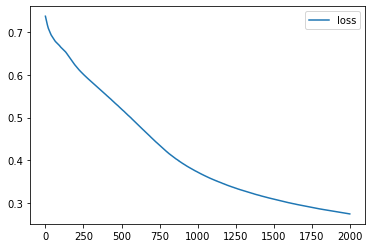

In [11]:
model_loss = pd.DataFrame(model1.history.history)
model_loss.plot()

In [12]:
predict_df["Win%"] = model1.predict(x=predict_df[input_columns].values)

display = predict_df.copy()
display[columns_to_scale1] = mov_scaler.inverse_transform(display[columns_to_scale1])
display[columns_to_scale2] = sos_scaler2.inverse_transform(display[columns_to_scale2])
display

1/1 [==============================] - 0s 58ms/step


,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA,Win%
Tm,,,,,,,,,,,,,,,
Chicago Bears,1.0,1,0,0,1.0,19,10,9,9.0,-9.0,0.0,0.0,0.0,0.655172,0.595993
Cincinnati Bengals,1.0,0,1,0,0.0,20,23,-3,-3.0,3.0,0.0,0.0,0.0,0.465116,0.621202
Detroit Lions,1.0,0,1,0,0.0,35,38,-3,-3.0,3.0,0.0,0.0,0.0,0.479452,0.579628
Green Bay Packers,0.0,0,1,0,0.0,7,23,-16,-16.0,16.0,0.0,0.0,0.0,0.233333,0.633051
Houston Texans,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,0.002379
Indianapolis Colts,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,0.002379
Jacksonville Jaguars,0.0,0,1,0,0.0,22,28,-6,-6.0,6.0,0.0,0.0,0.0,0.440000,0.845243
Los Angeles Rams,0.0,0,1,0,0.0,10,31,-21,-21.0,21.0,0.0,0.0,0.0,0.243902,0.548117
Minnesota Vikings,0.0,1,0,0,1.0,23,7,16,16.0,-16.0,0.0,0.0,0.0,0.766667,0.595993


<AxesSubplot:>

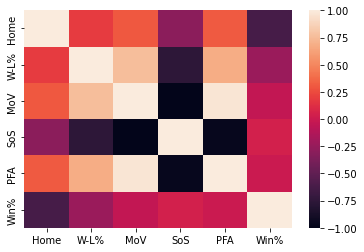

In [13]:
sns.heatmap(display[input_columns + ["Win%"]].corr())

### Make predictions using multiple linear regression

In [14]:
from sklearn.linear_model import LinearRegression

model2 = LinearRegression()
model2.fit(final_df[input_columns].values, final_df[output_column].values.ravel())

LinearRegression()

In [15]:
predict_df["Win%"] = model2.predict(predict_df[input_columns].values)

win_scaler = MinMaxScaler()
predict_df[["Win%"]] = win_scaler.fit_transform(predict_df[["Win%"]])

display = predict_df.copy()
display[columns_to_scale1] = mov_scaler.inverse_transform(display[columns_to_scale1])
display[columns_to_scale2] = sos_scaler2.inverse_transform(display[columns_to_scale2])
display

,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA,Win%
Tm,,,,,,,,,,,,,,,
Chicago Bears,1.0,1,0,0,1.0,19,10,9,9.0,-9.0,0.0,0.0,0.0,0.655172,0.345565
Cincinnati Bengals,1.0,0,1,0,0.0,20,23,-3,-3.0,3.0,0.0,0.0,0.0,0.465116,0.672585
Detroit Lions,1.0,0,1,0,0.0,35,38,-3,-3.0,3.0,0.0,0.0,0.0,0.479452,0.742664
Green Bay Packers,0.0,0,1,0,0.0,7,23,-16,-16.0,16.0,0.0,0.0,0.0,0.233333,0.310106
Houston Texans,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,0.371332
Indianapolis Colts,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,0.371332
Jacksonville Jaguars,0.0,0,1,0,0.0,22,28,-6,-6.0,6.0,0.0,0.0,0.0,0.440000,0.799487
Los Angeles Rams,0.0,0,1,0,0.0,10,31,-21,-21.0,21.0,0.0,0.0,0.0,0.243902,0.622219
Minnesota Vikings,0.0,1,0,0,1.0,23,7,16,16.0,-16.0,0.0,0.0,0.0,0.766667,0.619385


<AxesSubplot:>

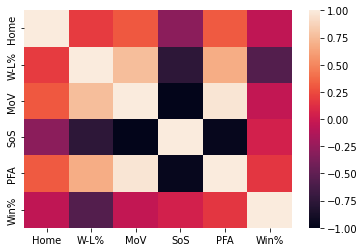

In [16]:
sns.heatmap(display[input_columns + ["Win%"]].corr())

### Make predictions using logistic regression

This is similar to multiple linear regression with an applied sigmoid function at the end to insure probability values between 0.0 and 1.0. It then rounds up to either 1.0 or 0.0 (win/loss). I'm still learning this one. Obviously, it picked way more wins than could reasonably be expected. I need to better calculate/transform/scale the inputs. The model is really confused by comparing 17 weeks of data and 1 week of data. The scaled values for MoV and SoS are completely out of whack.

In [17]:
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression()
model3.fit(final_df[input_columns].values, final_df[output_column].values.ravel())

LogisticRegression()

In [18]:
predict_df["Win%"] = model3.predict(predict_df[input_columns].values)

display = predict_df.copy()
display[columns_to_scale1] = mov_scaler.inverse_transform(display[columns_to_scale1])
display[columns_to_scale2] = sos_scaler2.inverse_transform(display[columns_to_scale2])
display

,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA,Win%
Tm,,,,,,,,,,,,,,,
Chicago Bears,1.0,1,0,0,1.0,19,10,9,9.0,-9.0,0.0,0.0,0.0,0.655172,0.0
Cincinnati Bengals,1.0,0,1,0,0.0,20,23,-3,-3.0,3.0,0.0,0.0,0.0,0.465116,1.0
Detroit Lions,1.0,0,1,0,0.0,35,38,-3,-3.0,3.0,0.0,0.0,0.0,0.479452,1.0
Green Bay Packers,0.0,0,1,0,0.0,7,23,-16,-16.0,16.0,0.0,0.0,0.0,0.233333,1.0
Houston Texans,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,1.0
Indianapolis Colts,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,1.0
Jacksonville Jaguars,0.0,0,1,0,0.0,22,28,-6,-6.0,6.0,0.0,0.0,0.0,0.440000,1.0
Los Angeles Rams,0.0,0,1,0,0.0,10,31,-21,-21.0,21.0,0.0,0.0,0.0,0.243902,1.0
Minnesota Vikings,0.0,1,0,0,1.0,23,7,16,16.0,-16.0,0.0,0.0,0.0,0.766667,0.0


<AxesSubplot:>

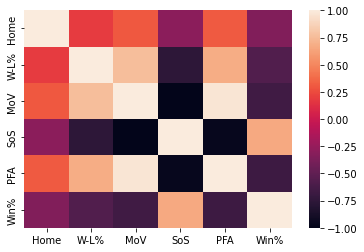

In [19]:
sns.heatmap(display[input_columns + ["Win%"]].corr())

### Make predictions using support vector machine regression

In [20]:
from sklearn.svm import SVR
model4 = SVR(kernel='rbf')
model4.fit(final_df[input_columns].values, final_df[output_column].values.ravel())

SVR()

In [21]:
predict_df["Win%"] = model4.predict(predict_df[input_columns].values)

display = predict_df.copy()
display[columns_to_scale1] = mov_scaler.inverse_transform(display[columns_to_scale1])
display[columns_to_scale2] = sos_scaler2.inverse_transform(display[columns_to_scale2])
display

,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA,Win%
Tm,,,,,,,,,,,,,,,
Chicago Bears,1.0,1,0,0,1.0,19,10,9,9.0,-9.0,0.0,0.0,0.0,0.655172,0.288136
Cincinnati Bengals,1.0,0,1,0,0.0,20,23,-3,-3.0,3.0,0.0,0.0,0.0,0.465116,0.633118
Detroit Lions,1.0,0,1,0,0.0,35,38,-3,-3.0,3.0,0.0,0.0,0.0,0.479452,0.632370
Green Bay Packers,0.0,0,1,0,0.0,7,23,-16,-16.0,16.0,0.0,0.0,0.0,0.233333,0.674760
Houston Texans,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,0.195785
Indianapolis Colts,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,0.195785
Jacksonville Jaguars,0.0,0,1,0,0.0,22,28,-6,-6.0,6.0,0.0,0.0,0.0,0.440000,1.009222
Los Angeles Rams,0.0,0,1,0,0.0,10,31,-21,-21.0,21.0,0.0,0.0,0.0,0.243902,0.609383
Minnesota Vikings,0.0,1,0,0,1.0,23,7,16,16.0,-16.0,0.0,0.0,0.0,0.766667,0.478858


<AxesSubplot:>

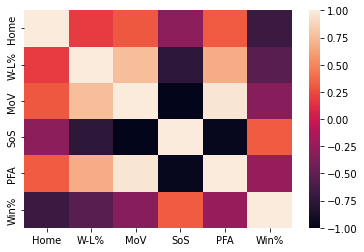

In [22]:
sns.heatmap(display[input_columns + ["Win%"]].corr())

### Make predictions using K Nearest Neighbors (KNN)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
model5 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
model5.fit(final_df[input_columns].values, final_df[output_column].values.ravel())

KNeighborsClassifier()

In [24]:
predict_df["Win%"] = model5.predict(predict_df[input_columns].values)

display = predict_df.copy()
display[columns_to_scale1] = mov_scaler.inverse_transform(display[columns_to_scale1])
display[columns_to_scale2] = sos_scaler2.inverse_transform(display[columns_to_scale2])
display

,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA,Win%
Tm,,,,,,,,,,,,,,,
Chicago Bears,1.0,1,0,0,1.0,19,10,9,9.0,-9.0,0.0,0.0,0.0,0.655172,0.0
Cincinnati Bengals,1.0,0,1,0,0.0,20,23,-3,-3.0,3.0,0.0,0.0,0.0,0.465116,1.0
Detroit Lions,1.0,0,1,0,0.0,35,38,-3,-3.0,3.0,0.0,0.0,0.0,0.479452,1.0
Green Bay Packers,0.0,0,1,0,0.0,7,23,-16,-16.0,16.0,0.0,0.0,0.0,0.233333,1.0
Houston Texans,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0
Indianapolis Colts,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0
Jacksonville Jaguars,0.0,0,1,0,0.0,22,28,-6,-6.0,6.0,0.0,0.0,0.0,0.440000,1.0
Los Angeles Rams,0.0,0,1,0,0.0,10,31,-21,-21.0,21.0,0.0,0.0,0.0,0.243902,1.0
Minnesota Vikings,0.0,1,0,0,1.0,23,7,16,16.0,-16.0,0.0,0.0,0.0,0.766667,0.0


<AxesSubplot:>

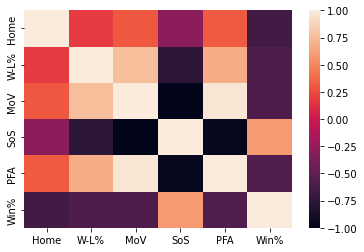

In [25]:
sns.heatmap(display[input_columns + ["Win%"]].corr())

### Make predictions using a Random Forest Classifer

In [26]:
from sklearn.ensemble import RandomForestClassifier
model6 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
model6.fit(final_df[input_columns].values, final_df[output_column].values.ravel())

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [27]:
predict_df["Win%"] = model6.predict(predict_df[input_columns].values)

display = predict_df.copy()
display[columns_to_scale1] = mov_scaler.inverse_transform(display[columns_to_scale1])
display[columns_to_scale2] = sos_scaler2.inverse_transform(display[columns_to_scale2])
display

,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA,Win%
Tm,,,,,,,,,,,,,,,
Chicago Bears,1.0,1,0,0,1.0,19,10,9,9.0,-9.0,0.0,0.0,0.0,0.655172,0.0
Cincinnati Bengals,1.0,0,1,0,0.0,20,23,-3,-3.0,3.0,0.0,0.0,0.0,0.465116,0.0
Detroit Lions,1.0,0,1,0,0.0,35,38,-3,-3.0,3.0,0.0,0.0,0.0,0.479452,0.0
Green Bay Packers,0.0,0,1,0,0.0,7,23,-16,-16.0,16.0,0.0,0.0,0.0,0.233333,1.0
Houston Texans,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,1.0
Indianapolis Colts,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,1.0
Jacksonville Jaguars,0.0,0,1,0,0.0,22,28,-6,-6.0,6.0,0.0,0.0,0.0,0.440000,1.0
Los Angeles Rams,0.0,0,1,0,0.0,10,31,-21,-21.0,21.0,0.0,0.0,0.0,0.243902,1.0
Minnesota Vikings,0.0,1,0,0,1.0,23,7,16,16.0,-16.0,0.0,0.0,0.0,0.766667,0.0


<AxesSubplot:>

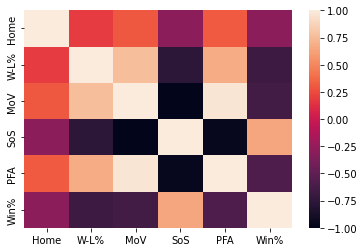

In [28]:
sns.heatmap(display[input_columns + ["Win%"]].corr())

### Make predictions using XGBoost

In [29]:
from xgboost import XGBClassifier
model7 = XGBClassifier()
model7.fit(final_df[input_columns].values, final_df[output_column].values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [30]:
predict_df["Win%"] = model7.predict(predict_df[input_columns].values)

display = predict_df.copy()
display[columns_to_scale1] = mov_scaler.inverse_transform(display[columns_to_scale1])
display[columns_to_scale2] = sos_scaler2.inverse_transform(display[columns_to_scale2])
display

,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA,Win%
Tm,,,,,,,,,,,,,,,
Chicago Bears,1.0,1,0,0,1.0,19,10,9,9.0,-9.0,0.0,0.0,0.0,0.655172,0
Cincinnati Bengals,1.0,0,1,0,0.0,20,23,-3,-3.0,3.0,0.0,0.0,0.0,0.465116,1
Detroit Lions,1.0,0,1,0,0.0,35,38,-3,-3.0,3.0,0.0,0.0,0.0,0.479452,1
Green Bay Packers,0.0,0,1,0,0.0,7,23,-16,-16.0,16.0,0.0,0.0,0.0,0.233333,1
Houston Texans,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,1
Indianapolis Colts,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,1
Jacksonville Jaguars,0.0,0,1,0,0.0,22,28,-6,-6.0,6.0,0.0,0.0,0.0,0.440000,1
Los Angeles Rams,0.0,0,1,0,0.0,10,31,-21,-21.0,21.0,0.0,0.0,0.0,0.243902,1
Minnesota Vikings,0.0,1,0,0,1.0,23,7,16,16.0,-16.0,0.0,0.0,0.0,0.766667,0


### Make predictions using CatBoost

In [31]:
from catboost import CatBoostClassifier
model8 = CatBoostClassifier(iterations=2,
                           learning_rate=1,
                           depth=2)
model8.fit(final_df[input_columns].values, final_df[output_column].values.ravel())

0:	learn: 0.5256397	total: 46.9ms	remaining: 46.9ms
1:	learn: 0.4965266	total: 47.2ms	remaining: 0us


In [32]:
predict_df["Win%"] = model8.predict(predict_df[input_columns].values)

display = predict_df.copy()
display[columns_to_scale1] = mov_scaler.inverse_transform(display[columns_to_scale1])
display[columns_to_scale2] = sos_scaler2.inverse_transform(display[columns_to_scale2])
display

,Home,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,PFA,Win%
Tm,,,,,,,,,,,,,,,
Chicago Bears,1.0,1,0,0,1.0,19,10,9,9.0,-9.0,0.0,0.0,0.0,0.655172,0.0
Cincinnati Bengals,1.0,0,1,0,0.0,20,23,-3,-3.0,3.0,0.0,0.0,0.0,0.465116,1.0
Detroit Lions,1.0,0,1,0,0.0,35,38,-3,-3.0,3.0,0.0,0.0,0.0,0.479452,1.0
Green Bay Packers,0.0,0,1,0,0.0,7,23,-16,-16.0,16.0,0.0,0.0,0.0,0.233333,1.0
Houston Texans,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,1.0
Indianapolis Colts,1.0,0,0,1,0.5,20,20,0,0.0,0.0,0.0,0.0,0.0,0.500000,1.0
Jacksonville Jaguars,0.0,0,1,0,0.0,22,28,-6,-6.0,6.0,0.0,0.0,0.0,0.440000,1.0
Los Angeles Rams,0.0,0,1,0,0.0,10,31,-21,-21.0,21.0,0.0,0.0,0.0,0.243902,1.0
Minnesota Vikings,0.0,1,0,0,1.0,23,7,16,16.0,-16.0,0.0,0.0,0.0,0.766667,1.0
